In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import pickle
import numpy as np
import re

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [31]:
table_dict = {}
while True:
    page = requests.get('http://192.168.100.1/cmSignalData.htm', timeout=10)
    soup = bs(page.content, 'html.parser')
    tables = soup.find_all('tbody')
    t_now = pd.Timestamp.now()
    table_dict[t_now] = {}
    for table in tables:
        rows = table.find_all('tr')
        for i, row in enumerate(rows):
            if i == 0:
                cols = row.find_all('th')
                if len(cols) == 0: break
                cols = [ele.text.strip() for ele in cols]
                table_name = cols[0]
                table_dict[t_now][table_name] = {}
                data = []
            else:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                data.append(cols)
            for d in data:
                if 'The Downstream Power Level reading' in d[0] and len(d)>1:
                    d[0] = 'Power Level'
                    del d[1]
                if d[0].startswith('The Downstream Power Level reading'):
                    continue
                table_dict[t_now][table_name][d[0]] = d[1:]
        table_dict[t_now][table_name] = pd.DataFrame.from_dict(table_dict[t_now][table_name])
        with open('D:\Code\modem_data_6.pickle', 'wb') as f:
            pickle.dump(table_dict, f, protocol=4)
    time.sleep(1)

ConnectTimeout: HTTPConnectionPool(host='192.168.100.1', port=80): Max retries exceeded with url: /cmSignalData.htm (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000002AAD540B0F0>, 'Connection to 192.168.100.1 timed out. (connect timeout=10)'))

In [3]:
with open('D:\Code\modem_data_3.pickle', 'rb') as f:
    table_dict = pickle.load(f)

In [26]:
snr = np.zeros((30,len(table_dict)))
for j, k in enumerate(table_dict.keys()):
    values = table_dict[k]['Downstream']['Signal to Noise Ratio'].values
    ID_values = table_dict[k]['Downstream']['Channel ID'].values
    for i, value in enumerate(values):
        ID = int(ID_values[i])
        number = int(re.split(r'\D* dB', value)[0])
        snr[ID, j] = number

In [27]:
power = np.zeros((5,len(table_dict)))
for j, k in enumerate(table_dict.keys()):
    values = table_dict[k]['Upstream']['Power Level'].values
    ID_values = table_dict[k]['Upstream']['Channel ID'].values
    for i, value in enumerate(values):
        ID = int(ID_values[i])
        number = int(re.split(r'\D* dBmV', value)[0])
        power[ID, j] = number

In [28]:
keys = list(table_dict.keys())

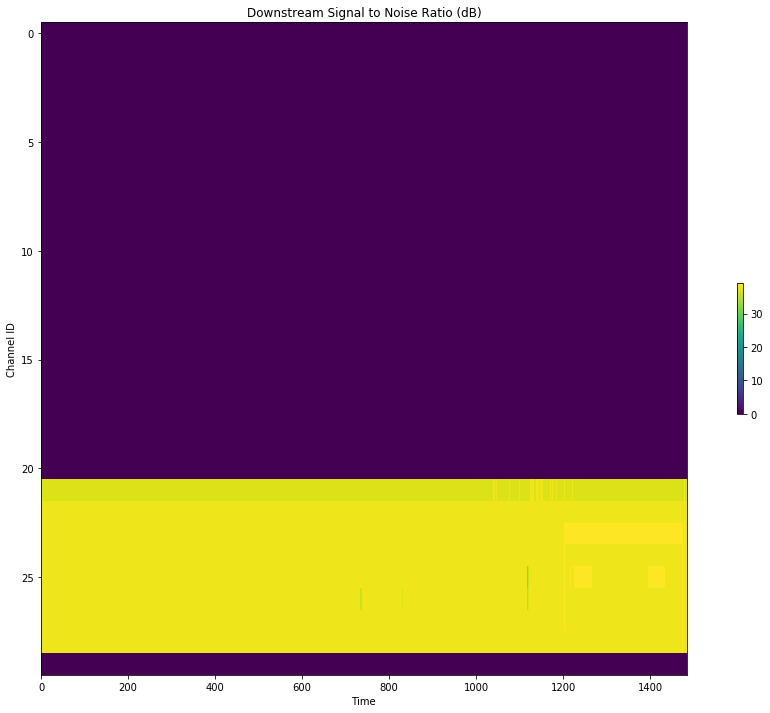

In [29]:
plt.figure(figsize=[18,12])
# plt.imshow(np.r_[snr[19:22], snr[23:28]])
# plt.imshow(snr[1:8])
plt.imshow(snr)
ax = plt.gca()
ax.set_aspect(50)
# plt.clim((35,40))
plt.colorbar(shrink=0.2)
# plt.yticks(range(8), ['13', '15', '16', '17', '18', '19', '20', '21'])
plt.ylabel('Channel ID')
# x_axis = np.arange(0, 1501, 250)
# xlabels = [''.join([str(keys[i].hour),':',str(keys[i].minute),':',str(keys[i].second)]) for i in x_axis]
# plt.xticks(x_axis, xlabels, rotation=45)
plt.xlabel('Time')
plt.title('Downstream Signal to Noise Ratio (dB)')
plt.show()

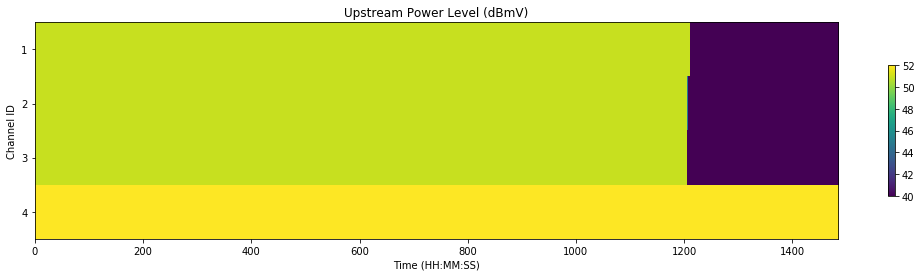

In [30]:
plt.figure(figsize=[18,12])
plt.imshow(power[1:5])
ax = plt.gca()
ax.set_aspect(100)
# plt.clim((35,40))
plt.colorbar(shrink=0.2)
plt.yticks(range(4), ['1', '2', '3', '4'])
plt.ylabel('Channel ID')
# x_axis = np.arange(600, 1001, 50)
# xlabels = [''.join([str(keys[i].hour),':',str(keys[i].minute),':',str(keys[i].second)]) for i in x_axis]
# plt.xticks(x_axis-600, xlabels, rotation=45)
plt.xlabel('Time (HH:MM:SS)')
plt.title('Upstream Power Level (dBmV)')
plt.show()